# Is the new Puskás Stadium in Budapest really too expensive?

> **Abstract:** While [444](http://www.444.hu) claims that the new national stadium in Hungary, Puskás Stadium, is unrealisically expensive, the data they provide to prove this claim shows the exact opposite: based on the number of seats, the stadium costs almost exactly as much as we would expect.

Hungarian online newspaper [444](http://www.444.hu) has recently published an [article](https://444.hu/2017/02/27/egyaltalan-nem-igaz-hogy-realis-az-uj-puskas-stadion-140-milliardos-koltsege) stating that the new national stadium in Hungary, Puskás, is unrealistically expensive, since it costs €6740/seat to build. They even collected data on other stadiums: their capacity and building costs.

My goal is to see whether the claim that the cost of this specific stadium is too high is justified – using the data provided in the article.

Let's import some packages to work with:

In [1]:
# this makes sure matplotlib plots are displayed inline (later on):
%matplotlib inline 

import pandas as pd
import numpy as np

## Data collection and manipulation

Luckily, Pandas has exceptional HTML-reading capabilities, so we can import the table from the article in one line of code. We have to ignore the first line (as that is the overall title of the table) and set the thousands separator to '.'. The table is the first (and only) one in the article that `pandas` finds, so I take the first element of the list of results. Finally I remove the last line of the table since that countains the source.

In [2]:
stadiums = pd.read_html('https://444.hu/2017/02/27/egyaltalan-nem-igaz-hogy-realis-az-uj-puskas-stadion-140-milliardos-koltsege'
                        , skiprows=1, header=0, thousands='.')[0][:-1]

Using domain knowledge (knowledge of the Hungarian language), let's change the column names and column values to English (n.b.: overall costs are in million €s, per-seat costs in €s, but this is omitted for brevity):

In [3]:
country_names = {'Anglia':'England',u'Azerbajdzsán':'Azerbaijan',u'Belgium':'Belgium',u'Bulgária':'Bulgaria',u'Fehéroroszo.':'Belarussia',u'Franciao.':'France',u'Lengyelo.':'Poland',u'Magyaro.':'Hungary',u'Németo.':'Germany',u'Olaszo.':'Italy',u'Oroszo.':'Russia',u'Románia':'Romania',u'Spanyolo.':'Spain'}

stadiums.columns = ['name', 'country', 'city', 'nr_seats', 'cost', 'cost_per_seat', 'reason_for_construction']
stadiums['country'] = stadiums['country'].map(country_names)
stadiums['name'] = stadiums['name'].apply(lambda x: 'National Stadium' if x == u'Nemzeti stadion' else x)
stadiums.index = stadiums[['name', 'country']].apply(lambda x: ', '.join(x), axis=1)

We will only need a few columns, so let's keep only those:

In [4]:
stadiums = stadiums[['nr_seats', 'cost', 'cost_per_seat']]

Let's check if our data is indeed correct:

In [5]:
stadiums.head(3)

,nr_seats,cost,cost_per_seat
"National Stadium, Bulgaria",33621,"49,5",1472
"Nagyerdei, Hungary",20340,40,1982
"Groupama Aréna (FTC), Hungary",22000,47,2160


Unfortunately, the Cost column is still a string as the `read_html` method does not allow the specify the decimal separator, which is a comma in Hungarian. Let's fix that by replacing the comma with a period, then turning the string to a float in the Cost column.

While we're there, let's also multiply the costs by 1,000,000 so that we get the actual € cost.

In [6]:
stadiums['cost'] = stadiums['cost'].map(lambda x: float(x.replace(',','.'))*1e6)

## Visual inspection of the data

Let's look at our full data table now that we have it in its proper form:

In [7]:
stadiums.head(30)

,nr_seats,cost,cost_per_seat
"National Stadium, Bulgaria",33621,49500000,1472
"Nagyerdei, Hungary",20340,40000000,1982
"Groupama Aréna (FTC), Hungary",22000,47000000,2160
"Juventus, Italy",41000,105000000,2560
"Pancho Aréna, Hungary",3500,12000000,3500
"Traktor, Belarussia",31000,115000000,3709
"San Memés, Spain",53289,198000000,3735
"Vélodrome, France",67394,267000000,3961
"National Stadium, Romania",55634,234000000,4206
"Hidegkuti (MTK), Hungary",5332,23000000,4394


It is always a good idea to look at a scatterplot to have a visual understading between the variables of interest. 

It is hard to form a hypothesis about the seat number – cost relationship as it there could be economies of scale when building stadiums (i.e. the cost of an extra seat goes down with the number of seats), or larger stadiums could have even higher per-chair cost as they have extra facilities, equipment, areas for other sports other than football, security systems, etc.

Looking at the relationship between the number of seats and the cost per seat, the relationship seems to be somewhat J-shaped with a minimum cost per seat at around 30,000 seats:

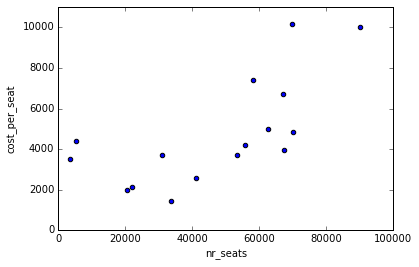

In [8]:
stadiums.plot(kind='scatter', x='nr_seats', y=u'cost_per_seat', ylim=(0,1.1e4), xlim=(0,1e5))

In our case to see whether Puskás Stadium really is too expensive, let's look at the general relationship between number of seats and total costs. This plot is shown below:

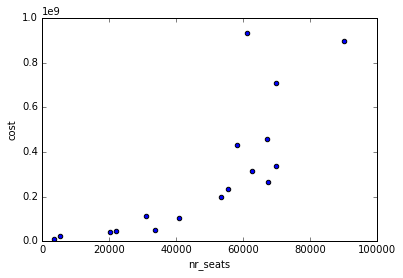

In [9]:
stadiums.plot(kind='scatter', x='nr_seats', y=u'cost', ylim=(0,1e9), xlim=(0,1e5))

Looking at the graph above shows that the relationship is not linear; it looks exponential: the marginal cost of seats increases with stadium size. So let's take the logarithm of the cost (to counter the exponential relationship) and display that data. 

In the figure below I use the `seaborn` package because it makes it very easy to add a regression line to a scatterplot:

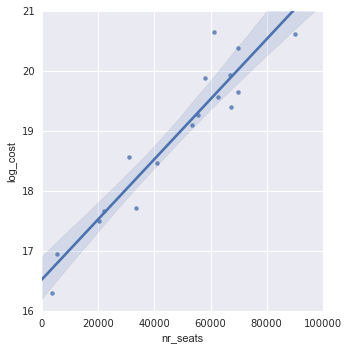

In [10]:
import seaborn as sns

stadiums['log_cost'] = stadiums['cost'].map(np.log)
p = sns.lmplot(x="nr_seats", y="log_cost", data=stadiums);
p.set(ylim=(16, 21), xlim = (0, 1e5))


This relationship seems pretty solid, the number of the seats in the stadium seems to explain the logarithm of the price of the stadium quite well!

To learn more about this relationship, let's run a regression model on this data.

## Regression analysis and comparison of actual costs to predicted costs

For the [regression analysis](https://en.wikipedia.org/wiki/Regression_analysis), I will use the statsmodels package. A detailed tutorial can be found [here](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/ols.html). 

The line in the figure above is already the visual represenatation of a fitted regression model, where we assumed that the relationship between the number of seats and the cost of the stadium is as follows:

$$\ln(\textit{cost}) = \beta_0 + \beta_1 \cdot \textit{nr_seats} + \varepsilon$$

The model has the intercept ($\beta_0$) and the slope ($\beta_1$) of this linear relationship, and $\varepsilon$ is an error term since we cannot realistically expect all observations to fall exactly on the line. We can estimate these parameters from the data and predict the log cost for each stadium based on its number of seats:

$$\hat{\ln(\textit{cost})} = \hat{\beta_0} + \hat{\beta_1} \cdot \textit{nr_seats}$$

I will use these to assess how much the predicted log cost given the number of seats differs from the actual stadium cost. 

Those familiar with regression analysis can download this notebook and run ```results.summary()``` to see the details of the model.

In [11]:
import statsmodels.api as sm

In [12]:
y = stadiums['log_cost']
X = stadiums['nr_seats']
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print('Parameters: ', list(results.params))
print('R2: ', results.rsquared)

('Parameters: ', [16.524423597010077, 5.0149327345107249e-05])
('R2: ', 0.90103527307801023)


The model has been calculated above and stored in the `results` object. The estimated intercept is 16.52; the estimated slope of the curve is 0.00005. Due to the mathematical properties of the model, this can be interpreted as each chair increasing the price of the stadium by 0.005% [(Benoit, 2011)](http://www.kenbenoit.net/courses/ME104/logmodels2.pdf).

The adjusted $R^2$, shown above, shows that the model is actually a very good fit for one variable: about 90% of the variation in the log price are explained by the number of seats in a stadium.

Let's calculate the predicted cost for each of the stadiums based on the number of their seats (we take the exponential of the predicted log price to get actual € values).

In [13]:
stadiums['predicted_cost'] = np.exp(results.predict(X))

Also, let's calculate the difference between the actual and predicted values (i.e. an estimated cost overrun) both in € and percentage terms; this will allow us to see whether Puskás really is an irreasonably expensive:

In [14]:
stadiums['cost_difference'] = stadiums['cost'] - stadiums['predicted_cost']
stadiums['cost_difference_perc'] = (stadiums['cost'] / stadiums['predicted_cost'] - 1) * 100

Plotting the cost overrun in relative terms (i.e. as a percentage of the predicted cost) and in €s:

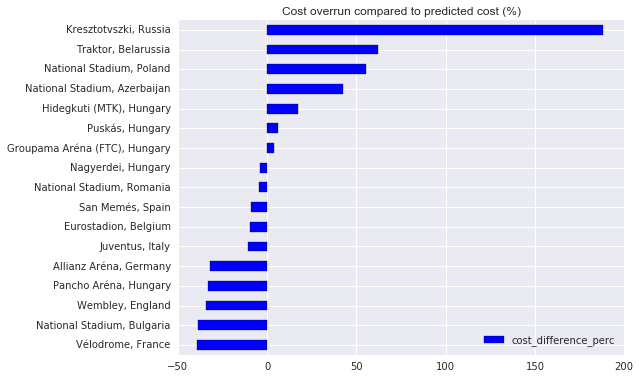

In [15]:
stadiums[['cost_difference_perc']].sort_values('cost_difference_perc').plot(
    kind = 'barh', title='Cost overrun compared to predicted cost (%)', figsize=(8,6))

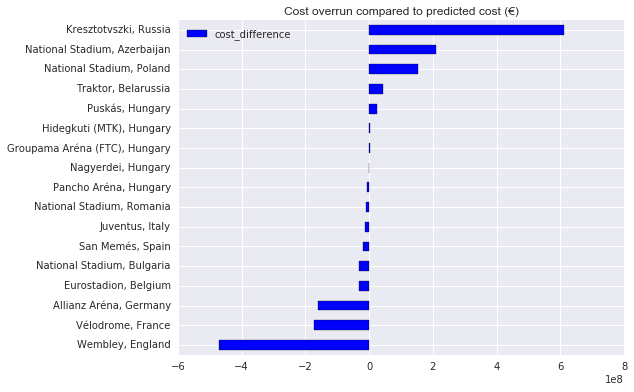

In [16]:
stadiums[['cost_difference']].sort_values('cost_difference').plot(
    kind = 'barh', title=u'Cost overrun compared to predicted cost (€)', figsize=(8,6))

We can see that while Puskás is indeed somewhat more expensive than we would expect based on its size, the difference is not very large compared to other cases.

## Summary of results

In the analysis above I briefly looked at the relationship between the number of seats in a stadium and the total cost of construction. I have found that this is indeed a strong relationship: the number of seats seems to be a good predictor of the cost.

An interesting observation regarding this (very small!) dataset is that stadiums that were built in countries typically associated with higher corruption levels tend to overrun more as compared to the predicted cost than those in lower-corruption-level countries.

The claim of the article mentioned in the beginning of this analysis that Puskás is too expensive does not seem to be supported by the data they provide – it might be very expensive, but that is then because of its size. My analysis cannot help to decide whether the size of Puskás Stadium is ideal; it only concludes that for this size this price is not too far from what is expected. 

Of course, it would be much better to control for country-specific effects (e.g. overall price/wage levels, corruption levels, popularity of football), or individual characteristics of the stadiums (e.g. number of inhabitants in the city, terrain, facilities). Such features would allow for a more roboust analysis of the costs as well as potential for predicting the 'right' size of the stadium, but they were not available for this short exercise.

## Appendix: full data table with calculated columns
### As a Pandas DataFrame

In [17]:
stadiums

,nr_seats,cost,cost_per_seat,log_cost,predicted_cost,cost_difference,cost_difference_perc
"National Stadium, Bulgaria",33621,49500000,1472,17.717483,8.104330e+07,-3.154330e+07,-38.921539
"Nagyerdei, Hungary",20340,40000000,1982,17.504390,4.163538e+07,-1.635383e+06,-3.927868
"Groupama Aréna (FTC), Hungary",22000,47000000,2160,17.665658,4.524980e+07,1.750200e+06,3.867863
"Juventus, Italy",41000,105000000,2560,18.469471,1.173353e+08,-1.233528e+07,-10.512847
"Pancho Aréna, Hungary",3500,12000000,3500,16.300417,1.789347e+07,-5.893467e+06,-32.936418
"Traktor, Belarussia",31000,115000000,3709,18.560443,7.106125e+07,4.393875e+07,61.832221
"San Memés, Spain",53289,198000000,3735,19.103778,2.173091e+08,-1.930905e+07,-8.885526
"Vélodrome, France",67394,267000000,3961,19.402759,4.408377e+08,-1.738377e+08,-39.433494
"National Stadium, Romania",55634,234000000,4206,19.270832,2.444280e+08,-1.042798e+07,-4.266280
"Hidegkuti (MTK), Hungary",5332,23000000,4394,16.951005,1.961529e+07,3.384712e+06,17.255481


### As ready-to-copy-paste csv

In [18]:
print stadiums.to_csv(encoding='utf8')

,nr_seats,cost,cost_per_seat,log_cost,predicted_cost,cost_difference,cost_difference_perc
"National Stadium, Bulgaria",33621.0,49500000.0,1472.0,17.7174832275,81043299.5115,-31543299.5115,-38.9215391052
"Nagyerdei, Hungary",20340.0,40000000.0,1982.0,17.5043900121,41635382.9421,-1635382.94207,-3.92786814125
"Groupama Aréna (FTC), Hungary",22000.0,47000000.0,2160.0,17.6656581597,45249799.5652,1750200.43478,3.86786339741
"Juventus, Italy",41000.0,105000000.0,2560.0,18.4694709081,117335277.946,-12335277.9459,-10.512846743
"Pancho Aréna, Hungary",3500.0,12000000.0,3500.0,16.3004172078,17893467.1895,-5893467.18954,-32.9364182308
"Traktor, Belarussia",31000.0,115000000.0,3709.0,18.5604426863,71061250.3935,43938749.6065,61.8322213065
"San Memés, Spain",53289.0,198000000.0,3735.0,19.1037775887,217309052.184,-19309052.1844,-8.88552593199
"Vélodrome, France",67394.0,267000000.0,3961.0,19.4027592164,440837711.305,-173837711.305,-39.4334937432
"National Stadium, Romania",55634.0,234000000.0,4206.0,